In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import os
print(os.listdir('../input/dogs-vs-cats'))

['test1.zip', 'train.zip', 'sampleSubmission.csv']


In [2]:
import zipfile

train_zip = zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip")
train_zip.extractall("/kaggle/working/dataset")
train_zip.close()

In [3]:
import zipfile

train_zip = zipfile.ZipFile("../input/dogs-vs-cats/test1.zip")
train_zip.extractall("/kaggle/working/dataset")
train_zip.close()

In [4]:
Image_width = 128
Image_height = 128
Image_size = (Image_width , Image_height)
Image_channel = 3

Image_rgb_size = (Image_width ,Image_height , 3 )

In [5]:
filenames = os.listdir('./dataset/train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
data = pd.DataFrame({'filename' : filenames , 'category' : categories})
data.head()

,filename,category
0,cat.8361.jpg,0
1,dog.2708.jpg,1
2,dog.816.jpg,1
3,dog.11248.jpg,1
4,dog.5217.jpg,1


In [6]:
data['category'].value_counts()

0    12500
1    12500
Name: category, dtype: int64

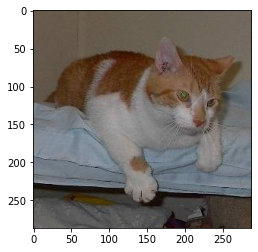

In [7]:
import random
sample = random.choice(filenames)
image = load_img('./dataset/train/{}'.format(sample))
plt.imshow(image)

In [8]:
data['category1'] = data['category'].apply(lambda x: 'cat' if x== 0 else 'dog')
data.head()

,filename,category,category1
0,cat.8361.jpg,0,cat
1,dog.2708.jpg,1,dog
2,dog.816.jpg,1,dog
3,dog.11248.jpg,1,dog
4,dog.5217.jpg,1,dog


In [9]:
data.drop(['category'] , inplace = True , axis = 1)
data.rename(columns  = {'category1' : 'category'} , inplace =True)
data.head()

,filename,category
0,cat.8361.jpg,cat
1,dog.2708.jpg,dog
2,dog.816.jpg,dog
3,dog.11248.jpg,dog
4,dog.5217.jpg,dog


In [10]:
train_df , val_df = train_test_split(data , test_size = 0.2 , random_state = 42)
train_df = train_df.reset_index(drop = True)
val_df = val_df.reset_index(drop = True)

In [11]:
train_df.shape , val_df.shape

((20000, 2), (5000, 2))

In [12]:
batch_size  = 15
epochs = 7 #due to speed
total_train = train_df.shape[0]
total_validate = val_df.shape[0]

In [13]:
train_dategen = ImageDataGenerator(rotation_range = 15 , 
                                  rescale = 1.0/255 ,
                                  shear_range = 0.1,
                                  zoom_range = 0.2 , 
                                  horizontal_flip = True , 
                                  width_shift_range = 0.1 , 
                                  height_shift_range = 0.1
                                  )

In [14]:
train_generator = train_dategen.flow_from_dataframe(
    train_df, 
    "./dataset/train", 
    x_col='filename',
    y_col='category',
    target_size=Image_size,
    class_mode='categorical',
    batch_size=batch_size
)  

Found 20000 validated image filenames belonging to 2 classes.


In [15]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = validation_datagen.flow_from_dataframe(
    val_df, 
    "./dataset/train", 
    x_col='filename',
    y_col='category',
    target_size=Image_size,
    class_mode='categorical',
    batch_size=batch_size
)  

Found 5000 validated image filenames belonging to 2 classes.


In [16]:
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

In [20]:
import tensorflow

In [21]:
from  tensorflow.keras.models import Sequential
from  tensorflow.keras.layers import Conv2D , MaxPooling2D , Dropout , Flatten , Dense , Activation , BatchNormalization

base = tensorflow.keras.applications.resnet50.ResNet50(weights = 'imagenet' , include_top = False , input_shape = Image_rgb_size)


2022-11-20 07:35:07.788630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 07:35:07.789529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 07:35:07.969857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 07:35:07.970751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 07:35:07.971640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

94781440/94765736 [==============================] - 1s 0us/step


In [22]:
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(2, activation= 'softmax')(x)
model = Model(inputs = base.input, outputs = predictions)

In [23]:
from tensorflow.keras.optimizers import Adam 
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(learning_rate=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [25]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop , learning_rate_reduction]

In [26]:
history = model.fit_generator(
    train_generator , 
    epochs = epochs , 
    validation_data=val_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-20 07:35:29.852825: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-11-20 07:35:36.386646: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1333/1333 [==============================] - 202s 141ms/step - loss: 0.2288 - accuracy: 0.9099 - val_loss: 0.1735 - val_accuracy: 0.9405
Epoch 2/50
1333/1333 [==============================] - 185s 139ms/step - loss: 0.1268 - accuracy: 0.9526 - val_loss: 0.0799 - val_accuracy: 0.9678
Epoch 3/50
1333/1333 [==============================] - 194s 145ms/step - loss: 0.0980 - accuracy: 0.9625 - val_loss: 0.0996 - val_accuracy: 0.9602
Epoch 4/50
1333/1333 [==============================] - 204s 153ms/step - loss: 0.0915 - accuracy: 0.9667 - val_loss: 0.1100 - val_accuracy: 0.9598
Epoch 5/50
1333/1333 [==============================] - 188s 141ms/step - loss: 0.0772 - accuracy: 0.9709 - val_loss: 0.0958 - val_accuracy: 0.9614
Epoch 6/50
1333/1333 [==============================] - 201s 151ms/step - loss: 0.0774 - accuracy: 0.9709 - val_loss: 0.3343 - val_accuracy: 0.9299
Epoch 7/50
1333/1333 [==============================] - 184s 138ms/step - loss: 0.0790 - accuracy: 0.9716 - val_loss: 0.070

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fa6fa9864d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 9/50
  35/1333 [..............................] - ETA: 2:36 - loss: 0.0590 - accuracy: 0.9771

KeyboardInterrupt: 

In [27]:
model.save_weights('model.h5')

In [30]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
# ax1.plot(history.history['loss'], color='b', label="Training loss")
# ax1.plot(history.history['val_loss'], color='r', label="validation loss")
# ax1.set_xticks(np.arange(1, epochs, 1))
# ax1.set_yticks(np.arange(0, 1, 0.1))

# ax2.plot(history.history['acc'], color='b', label="Training accuracy")
# ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
# ax2.set_xticks(np.arange(1, epochs, 1))

# legend = plt.legend(loc='best', shadow=True)
# plt.tight_layout()
# plt.show()

In [32]:
test_filenames = os.listdir('./dataset/test1')
test = pd.DataFrame({'filename' : test_filenames})
nb_samples = test.shape[0]

In [35]:
test.head()

,filename
0,1366.jpg
1,8940.jpg
2,9869.jpg
3,8406.jpg
4,11331.jpg


In [36]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test , 
    './dataset/test1' ,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=Image_size,
    batch_size=batch_size,
    shuffle=False
    )

Found 12500 validated image filenames.


In [38]:
predict = model.predict_generator(test_generator , steps = np.ceil(nb_samples/batch_size))
test['category'] = np.argmax(predict  , axis= -1)
test.head()

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


,filename,category
0,1366.jpg,1
1,8940.jpg,1
2,9869.jpg,1
3,8406.jpg,0
4,11331.jpg,1


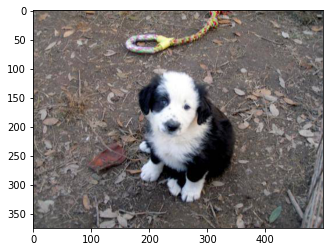

In [49]:
image = load_img('./dataset/test1/{}'.format('1366.jpg'))
plt.imshow(image)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='category', ylabel='count'>

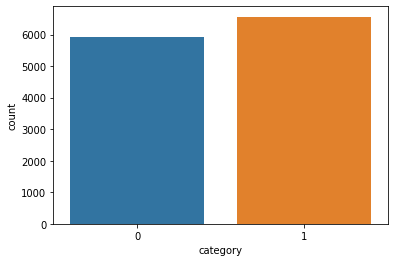

In [50]:
sns.countplot(test['category'])

In [51]:
submission_df = test.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.head()

,filename,category,id,label
0,1366.jpg,1,1366,1
1,8940.jpg,1,8940,1
2,9869.jpg,1,9869,1
3,8406.jpg,0,8406,0
4,11331.jpg,1,11331,1


In [52]:
submission_df.drop(['filename' , 'category'] , axis = 1 , inplace = True)
submission_df.to_csv('submission.csv', index=False)